In [2]:
import os
import logging
from pathlib import Path
from glob import glob
import warnings
warnings.simplefilter("ignore", UserWarning)

import numpy as np
from tqdm import tqdm
import torch
from captum.attr import LayerGradCam, LayerAttribution

from sage.config import load_config
from sage.training.trainer import MRITrainer
from sage.visualization.vistool import plot_vismap, Assembled

logging.basicConfig(
    format="[%(asctime)s] %(levelname)s - %(name)s: %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger = logging.getLogger(__name__)

In [3]:
RESULT_DIR = "../resnet256_augmentation_checkpoints/"
checkpoint_lists = sorted(glob(f"{RESULT_DIR}/*"))

checkpoint = Path(checkpoint_lists[0])

In [4]:
def load_model_ckpts(path: Path, epoch: int):

    epoch = str(epoch).zfill(3)
    ckpts = dict()
    for model_name in ("encoder", "regressor"):

        ckpt = list(path.glob(f"./{model_name}/ep{epoch}*.pt"))
        assert len(ckpt) == 1
        ckpts[model_name] = ckpt[0]

    mae = float(str(ckpt[0]).split("mae")[-1].split(".pt")[0])

    return ckpts, mae

In [5]:
load_model_ckpts(checkpoint, 0)

({'encoder': WindowsPath('../resnet256_augmentation_checkpoints/20211001-1526_resnet/encoder/ep000_mae52.73.pt'),
  'regressor': WindowsPath('../resnet256_augmentation_checkpoints/20211001-1526_resnet/regressor/ep000_mae52.73.pt')},
 52.73)

In [4]:
cfg = load_config(Path(checkpoint, "config.yml"))
cfg.force_cpu = True

trainer = MRITrainer(cfg)
model = Assembled(trainer.models["encoder"], trainer.models["regressor"]).to("cuda")
ckpt_dict, mae = load_model_ckpts(checkpoint, 3)
model.load_weight(ckpt_dict)

Use cuda:0 as a device.
Output from encoder is 256.
Total Number of parameters: 3634533
TOTAL TRAIN 1044 | VALID 262 | TEST 146
MIXED PRECISION:: True
Weights successfully loaded!


In [12]:
layer_gc = LayerGradCam(model, model.encoder.layer1[0].conv1)

In [13]:
for x, y, d in trainer.test_dataloader:
    x, y, d = map(lambda x: x.to("cuda"), (x, y, d))
    break

In [27]:
attr = layer_gc.attribute(x)

TypeError: attribute() got an unexpected keyword argument 'align_corners'

In [29]:
upsampled_attr = LayerAttribution.interpolate(attr, (96, 96, 96), interpolate_mode="trilinear")

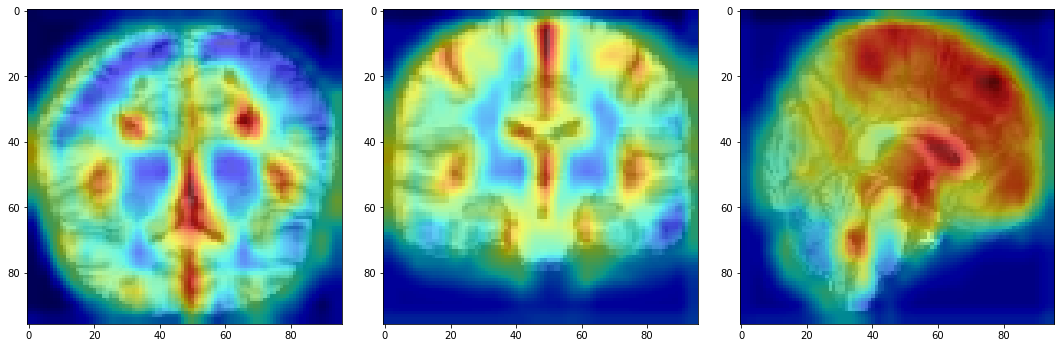

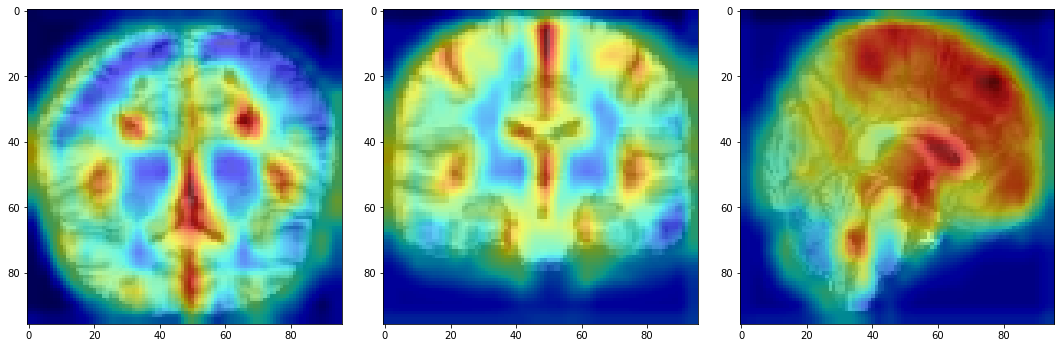

In [19]:
plot_vismap(x.cpu().detach(), upsampled_attr.cpu().detach(), masked=False)

In [6]:
for checkpoint in checkpoint_lists:

    checkpoint = Path(checkpoint)
    cfg = load_config(Path(checkpoint, "config.yml"))
    logger.info(f"Starting seed {cfg.seed}")
    cfg.force_cpu = True

    saliency_map_dir = Path(f"{checkpoint}/npy_maps/")
    os.makedirs(saliency_map_dir, exist_ok=True)
    trainer = MRITrainer(cfg)
    model = Assembled(trainer.models["encoder"], trainer.models["regressor"]).to("cuda")
    for e in range(0, 100):
        try:
            ckpt_dict, mae = load_model_ckpts(checkpoint, e)
            model.load_weight(ckpt_dict)
            logger.info(f"Load checkpoint epoch={e} | mae={mae}")
        except:
            break
        
        for layer_idx, conv_layer in tqdm(enumerate(model.conv_layers())):

            layer_save_dir = Path(f"{saliency_map_dir}/layer{layer_idx}/")
            os.makedirs(layer_save_dir, exist_ok=True)
            logger.info(f"Layer {layer_idx}: {conv_layer}")
            layer_gc = LayerGradCam(model, conv_layer)

            saliency_map = []
            for x, y, _ in trainer.test_dataloader:

                x, y = map(lambda x: x.to("cuda"), (x, y))
                attr = layer_gc.attribute(x)
                upsampled_attr = LayerAttribution.interpolate(attr, (96, 96, 96), interpolate_mode="trilinear").cpu().detach()
                saliency_map.append(upsampled_attr)

            saliency_map = torch.cat(saliency_map, dim=0).numpy()
            np.save(f"{layer_save_dir}/ep{str(e).zfill(3)}_mae{mae}.npy", saliency_map)

[12/07/2021 15:45:48] INFO - __main__: Starting seed 43


Use cuda:0 as a device.


[12/07/2021 15:45:53] INFO - __main__: Load checkpoint epoch=0 | mae=52.73
0it [00:00, ?it/s][12/07/2021 15:45:53] INFO - __main__: Layer 0: Conv3d(1, 32, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)


Output from encoder is 256.
Total Number of parameters: 3634533
TOTAL TRAIN 1044 | VALID 262 | TEST 146
MIXED PRECISION:: True
Weights successfully loaded!


1it [00:09,  9.36s/it][12/07/2021 15:46:02] INFO - __main__: Layer 1: Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
2it [00:17,  8.82s/it][12/07/2021 15:46:11] INFO - __main__: Layer 2: Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
3it [00:26,  8.77s/it][12/07/2021 15:46:19] INFO - __main__: Layer 3: Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
4it [00:34,  8.43s/it][12/07/2021 15:46:27] INFO - __main__: Layer 4: Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
5it [00:41,  8.10s/it][12/07/2021 15:46:35] INFO - __main__: Layer 5: Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
6it [00:49,  7.85s/it][12/07/2021 15:46:42] INFO - __main__: Layer 6: Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
7it [00:56,  7.53s/it][12/07/2021 15:46:49] INFO - __ma

Weights successfully loaded!


1it [00:07,  7.88s/it][12/07/2021 15:49:51] INFO - __main__: Layer 1: Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
2it [00:15,  7.89s/it][12/07/2021 15:49:59] INFO - __main__: Layer 2: Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
3it [00:24,  8.15s/it][12/07/2021 15:50:07] INFO - __main__: Layer 3: Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
4it [00:32,  8.08s/it][12/07/2021 15:50:15] INFO - __main__: Layer 4: Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
5it [00:42,  8.71s/it][12/07/2021 15:50:25] INFO - __main__: Layer 5: Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
6it [00:49,  8.42s/it][12/07/2021 15:50:33] INFO - __main__: Layer 6: Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
7it [00:57,  8.24s/it][12/07/2021 15:50:41] INFO - __ma

Use cuda:0 as a device.
Output from encoder is 256.
Total Number of parameters: 3634533
TOTAL TRAIN 1044 | VALID 262 | TEST 146
MIXED PRECISION:: True


[12/07/2021 15:51:48] INFO - __main__: Load checkpoint epoch=0 | mae=55.54
0it [00:00, ?it/s][12/07/2021 15:51:48] INFO - __main__: Layer 0: Conv3d(1, 32, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)


Weights successfully loaded!


1it [00:08,  8.80s/it][12/07/2021 15:51:57] INFO - __main__: Layer 1: Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
